In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

from optimizers.Lion import Lion
from optimizers.SignSGD import SignSGD
from utils import train_wrapper, generate_plots
from models.ImageNet import SimpleImageNet, DeeperImageNet

/Users/teframartin/EPFL_Cours/MA4/OptiMlForever/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


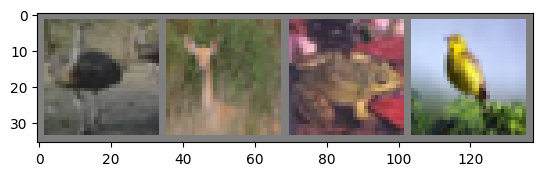

bird  deer  frog  bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Training

## 2.1 Compare optimizers (with/without scheduler)

### 2.1.1 Simple Net

In [5]:
model = SimpleImageNet

# SGD
net_sgd, losses_sgd = train_wrapper(model, optim.SGD, trainloader, device=device)
net_sgd_lw, losses_sgd_lw = train_wrapper(model, optim.SGD, trainloader, layer_wise=True, device=device)

# Adam
net_adam, losses_adam = train_wrapper(model, optim.Adam, trainloader, device=device)
net_adam_lw, losses_adam_lw = train_wrapper(model, optim.Adam, trainloader, layer_wise=True, device=device)

# AdaGrad
net_adagrad, losses_adagrad = train_wrapper(model, optim.Adagrad, trainloader, device=device)
net_adagrad_lw, losses_adagrad_lw = train_wrapper(model, optim.Adagrad, trainloader, layer_wise=True, device=device)

# SignSGD
net_signsgd, losses_signsgd = train_wrapper(model, SignSGD, trainloader, device=device)
net_signsgd_lw, losses_signsgd_lw = train_wrapper(model, SignSGD, trainloader, layer_wise=True, device=device)

# Lion
net_lion, losses_lion = train_wrapper(model, Lion, trainloader, device=device)
net_lion_lw, losses_lion_lw = train_wrapper(model, Lion, trainloader, layer_wise=True, device=device)


[1,  2000] loss: 2.302
[1,  4000] loss: 2.299
[1,  6000] loss: 2.291
[1,  8000] loss: 2.259
[1, 10000] loss: 2.214
[1, 12000] loss: 2.160
[2,  2000] loss: 2.086
[2,  4000] loss: 2.028
[2,  6000] loss: 1.973
[2,  8000] loss: 1.921
[2, 10000] loss: 1.875
[2, 12000] loss: 1.815
[3,  2000] loss: 1.757
[3,  4000] loss: 1.718
[3,  6000] loss: 1.666
[3,  8000] loss: 1.644
[3, 10000] loss: 1.628
[3, 12000] loss: 1.611
Finished Training
[1,  2000] loss: 2.302
[1,  4000] loss: 2.301
[1,  6000] loss: 2.296
[1,  8000] loss: 2.286
[1, 10000] loss: 2.255
[1, 12000] loss: 2.203
[2,  2000] loss: 2.138
[2,  4000] loss: 2.086
[2,  6000] loss: 2.007
[2,  8000] loss: 1.967
[2, 10000] loss: 1.923
[2, 12000] loss: 1.887
[3,  2000] loss: 1.802
[3,  4000] loss: 1.794
[3,  6000] loss: 1.742
[3,  8000] loss: 1.711
[3, 10000] loss: 1.697
[3, 12000] loss: 1.676
Finished Training
[1,  2000] loss: 1.874
[1,  4000] loss: 1.598
[1,  6000] loss: 1.483
[1,  8000] loss: 1.436
[1, 10000] loss: 1.384


[2.28517838 2.28526459 2.28516202 ... 1.25040102 1.25074695 1.25153719]
[2.15978974 2.16006681 2.15975747 ... 1.52310668 1.52435818 1.52521906]
[2.34295611 2.34296687 2.31966367 ... 2.31857728 2.31851675 2.31843406]
[2.34402326 2.34403549 2.31746687 ... 2.31814802 2.31808833 2.318111  ]
[2.17318855 2.17328778 2.10558327 ... 1.23590859 1.23668498 1.23618616]
[2.1197969  2.11920489 2.06441455 ... 1.24519291 1.24504778 1.245173  ]
[2.54377347 2.54417947 2.50748622 ... 3.05304593 3.05278292 3.05479922]
[2.61546519 2.61542895 2.608587   ... 2.54389556 2.54408309 2.54334985]
[2.17006151 2.16922133 2.16904733 ... 1.49868891 1.49895475 1.499832  ]
[2.11397782 2.1135755  2.11311471 ... 1.42605128 1.42559127 1.42605675]


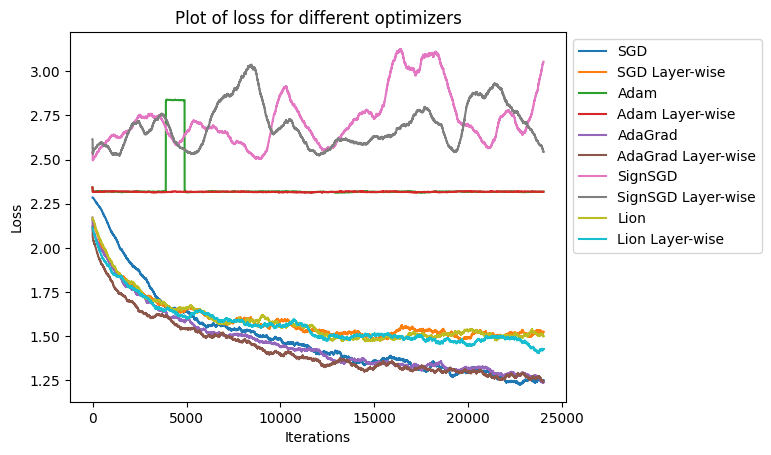

In [ ]:
from utils import generate_plots

losses = [
    losses_sgd,
    losses_sgd_lw,
    losses_adam,
    losses_adam_lw,
    losses_adagrad,
    losses_adagrad_lw,
    losses_signsgd,
    losses_signsgd_lw,
    losses_lion,
    losses_lion_lw
]

labels = [
    'SGD',
    'SGD Layer-wise',
    'Adam',
    'Adam Layer-wise',
    'AdaGrad',
    'AdaGrad Layer-wise',
    'SignSGD',
    'SignSGD Layer-wise',
    'Lion',
    'Lion Layer-wise'
]

generate_plots(losses, labels)

### 2.1.2 Complex Net

In [ ]:
model = DeeperImageNet().to(device)

# SGD
net_sgd, losses_sgd = train_wrapper(model, optim.SGD, trainloader, device=device)
net_sgd_lw, losses_sgd_lw = train_wrapper(model, optim.SGD, trainloader, layer_wise=True, device=device)

# Adam
net_adam, losses_adam = train_wrapper(model, optim.Adam, trainloader, device=device)
net_adam_lw, losses_adam_lw = train_wrapper(model, optim.Adam, trainloader, layer_wise=True, device=device)

# AdaGrad
net_adagrad, losses_adagrad = train_wrapper(model, optim.Adagrad, trainloader, device=device)
net_adagrad_lw, losses_adagrad_lw = train_wrapper(model, optim.Adagrad, trainloader, layer_wise=True, device=device)

# SignSGD
net_signsgd, losses_signsgd = train_wrapper(model, SignSGD, trainloader, device=device)
net_signsgd_lw, losses_signsgd_lw = train_wrapper(model, SignSGD, trainloader, layer_wise=True, device=device)

# Lion
net_lion, losses_lion = train_wrapper(model, Lion, trainloader, device=device)
net_lion_lw, losses_lion_lw = train_wrapper(model, Lion, trainloader, layer_wise=True, device=device)


In [ ]:
from utils import generate_plots

losses = [
    losses_sgd,
    losses_sgd_lw,
    losses_adam,
    losses_adam_lw,
    losses_adagrad,
    losses_adagrad_lw,
    losses_signsgd,
    losses_signsgd_lw,
    losses_lion,
    losses_lion_lw
]

labels = [
    'SGD',
    'SGD Layer-wise',
    'Adam',
    'Adam Layer-wise',
    'AdaGrad',
    'AdaGrad Layer-wise',
    'SignSGD',
    'SignSGD Layer-wise',
    'Lion',
    'Lion Layer-wise'
]

generate_plots(losses, labels)

- DS -> ≠ optimizers (avec/sans sceduler de base) -> courbe
    => prendre deux optimiser et tester ≠ scheduler 

TODO:
- add validation
- check for learning rates => do we need to have a specific learning rate for each optimizer or do we use the same one everywhere
- explore scheduler variation during the training => StepLR / CyclicLR / ReduceLROnPlateau / CosineAnnealingLR / LinearLR
- add speed per epoch
- try with an other dataset to compare
- (explore other learning rate schemes)
    1. Time-based Decay
    2. Step Decay
    3. Exponential Decay
    4. Cosine Annealing
    5. Cyclical Learning Rate (CLR)
    6. Warm Restarts (SGDR)
    7. Hyperbolic Tangent Decay
    8. One-cycle Learning Rate
    9. Polynomial Decay

In [ ]:
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau

net = Net()

optimizer = optim.SGD([
            {'params': net.conv1.parameters()},
            {'params': net.pool.parameters()},
            {'params': net.conv2.parameters()},
            {'params': net.fc1.parameters()},
            {'params': net.fc2.parameters()},
            {'params': net.fc3.parameters()}
        ], lr=0.001)

# scheduler = ReduceLROnPlateau(optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # StepLR as an example

net_sgd, losses_sgd = train_wrapper(optim.SGD, trainloader, device=device)
net_sgd_stepLR, losses_sgd_stepLR = train_wrapper(optim.SGD, trainloader, scheduler, device=device)
net_sgd_lw_stepLR, losses_sgd_lw_stepLR = train_wrapper(optim.SGD, trainloader, scheduler, layer_wise=True, device=device)

[1,  2000] loss: 2.189
[1,  4000] loss: 1.854
[1,  6000] loss: 1.652
[1,  8000] loss: 1.560
[1, 10000] loss: 1.511
[1, 12000] loss: 1.469
[2,  2000] loss: 1.393
[2,  4000] loss: 1.356
[2,  6000] loss: 1.343
[2,  8000] loss: 1.307
[2, 10000] loss: 1.292
[2, 12000] loss: 1.244
Finished Training
[1,  2000] loss: 2.246
[1,  4000] loss: 1.914
[1,  6000] loss: 1.722
[1,  8000] loss: 1.633
[1, 10000] loss: 1.555
[1, 12000] loss: 1.519
[2,  2000] loss: 1.444
[2,  4000] loss: 1.375
[2,  6000] loss: 1.389
[2,  8000] loss: 1.349
[2, 10000] loss: 1.323
[2, 12000] loss: 1.300
Finished Training
[1,  2000] loss: 2.227
[1,  4000] loss: 1.918
[1,  6000] loss: 1.739
[1,  8000] loss: 1.622
[1, 10000] loss: 1.570
[1, 12000] loss: 1.491
[2,  2000] loss: 1.453
[2,  4000] loss: 1.410
[2,  6000] loss: 1.368
[2,  8000] loss: 1.375
[2, 10000] loss: 1.311
[2, 12000] loss: 1.301
Finished Training


In [ ]:
net_sgd_lw_stepLR, losses_sgd_lw_stepLR = train_wrapper(optim.SGD, trainloader, scheduler, layer_wise=True, device=device)

[1,  2000] loss: 2.193
[1,  4000] loss: 1.889
[1,  6000] loss: 1.717
[1,  8000] loss: 1.613
[1, 10000] loss: 1.551
[1, 12000] loss: 1.486
[2,  2000] loss: 1.423
[2,  4000] loss: 1.398
[2,  6000] loss: 1.370
[2,  8000] loss: 1.347
[2, 10000] loss: 1.319
[2, 12000] loss: 1.288
Finished Training


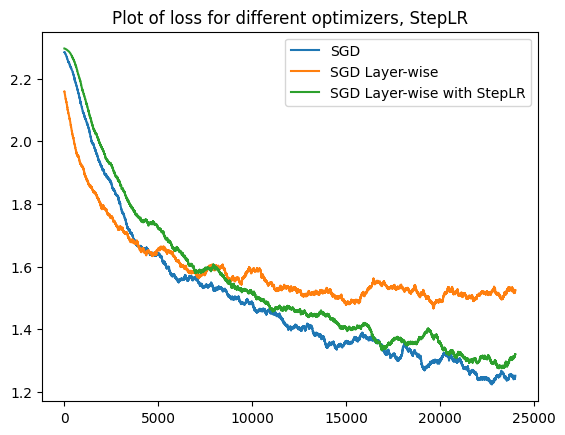

In [ ]:
moving_average_sgd = np.convolve(losses_sgd, np.ones(1000)/1000, mode='valid')
moving_average_sgd_lw = np.convolve(losses_sgd_lw, np.ones(1000)/1000, mode='valid')
moving_average_sgd_lw_stepLR = np.convolve(losses_sgd_lw_stepLR, np.ones(1000)/1000, mode='valid')

plt.plot(moving_average_sgd, label='SGD')
plt.plot(moving_average_sgd_lw, label='SGD Layer-wise')
plt.plot(moving_average_sgd_lw_stepLR, label='SGD Layer-wise with StepLR')
plt.legend()
plt.title(f"Plot of loss for different optimizers, StepLR")
plt.savefig(f"outputs/optimizer_comparison_StepLR.png")
plt.show()